**Step 1: Import Library**

In [1]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score
from art.attacks.evasion import DeepFool, FastGradientMethod, ProjectedGradientDescent
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from art.estimators.classification import TensorFlowV2Classifier
from art.defences.trainer import AdversarialTrainer

**Step 2: Load and Preprocess the Dataset**

In [3]:
# 1. Load and preprocess the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Shuffle the training data (optional but recommended)
shuffle_idx = np.random.permutation(len(x_train))
x_train = x_train[shuffle_idx]
y_train = y_train[shuffle_idx]


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
# Reshape data for the model input
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Normalize pixel values to range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [5]:
# Split into training, validation, and testing sets
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

In [6]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(x_train)

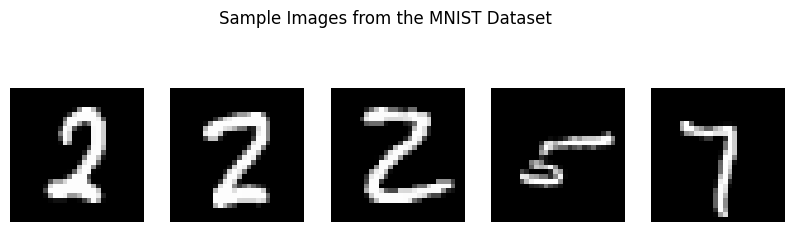

In [7]:
# Visualize sample images
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i in range(5):
    axes[i].imshow(x_train[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')
plt.suptitle("Sample Images from the MNIST Dataset")
plt.show()

**Step 3: Build and Train a CNN Model**

In [8]:
# Define the CNN model
from tensorflow.keras.layers import BatchNormalization
model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-5)

In [11]:
# Train the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_val, y_val),
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 37ms/step - accuracy: 0.7911 - loss: 0.7070 - val_accuracy: 0.9801 - val_loss: 0.0740 - learning_rate: 0.0010
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.9512 - loss: 0.1687 - val_accuracy: 0.9854 - val_loss: 0.0503 - learning_rate: 0.0010
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.9650 - loss: 0.1212 - val_accuracy: 0.9880 - val_loss: 0.0432 - learning_rate: 0.0010
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.9693 - loss: 0.1024 - val_accuracy: 0.9878 - val_loss: 0.0483 - learning_rate: 0.0010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9733 - loss: 0.0928 - val_accuracy: 0.9896 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.9752 - loss: 0.0949 - val_accuracy: 0.9903 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9808 - loss: 0.0728

In [12]:
# Evaluate the model on clean test data
clean_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Model accuracy on clean test data: {clean_accuracy[1]:.4f}")

Model accuracy on clean test data: 0.9911


**Step 4: Visualize Training Progress**

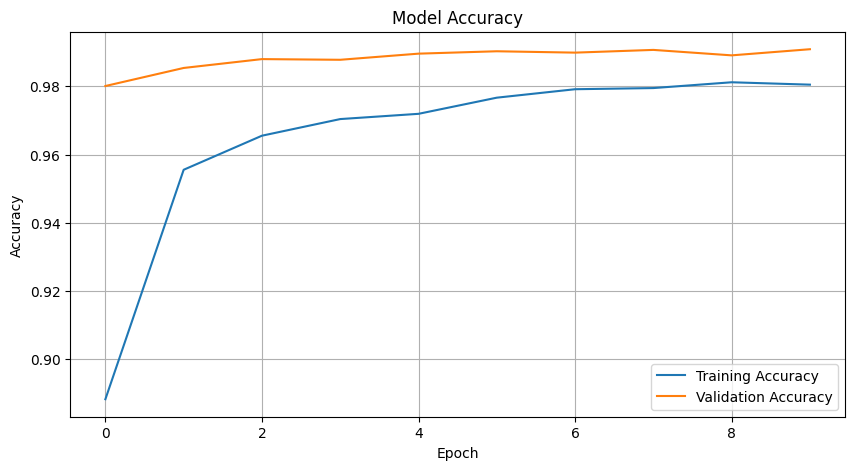

In [13]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

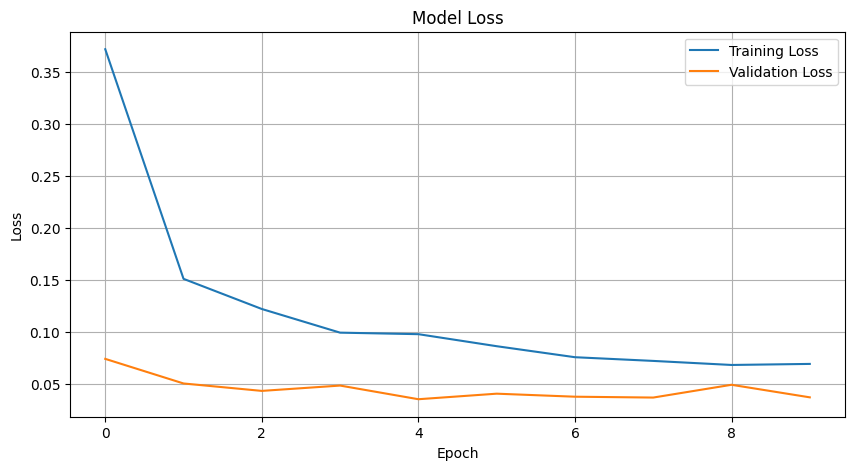

In [14]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Step 5: Generate Adversarial Examples using FGSM and PGD**

In [15]:
# # Create a TensorFlowV2Classifier for the ART library
# classifier = TensorFlowV2Classifier(
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=10,
    input_shape=(28, 28, 1),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    clip_values=(0.0, 1.0),  # Ensure input values are within [0, 1]
    optimizer=model.optimizer
)

In [16]:
# Generate adversarial examples using FGSM
fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.1)
x_test_adv_fgsm = fgsm_attack.generate(x=x_test, batch_size=32)

# Generate adversarial examples using PGD
pgd_attack = ProjectedGradientDescent(estimator=classifier, eps=0.1)
x_test_adv_pgd = pgd_attack.generate(x=x_test, batch_size=32)


PGD - Batches: 0it [00:00, ?it/s]

In [17]:
# # Evaluate the model on adversarial examples
# fgsm_accuracy = model.evaluate(x_test_adv_fgsm, y_test, verbose=0)
# pgd_accuracy = model.evaluate(x_test_adv_pgd, y_test, verbose=0)
# print(f"Model accuracy on FGSM adversarial data: {fgsm_accuracy[1]:.4f}")
# print(f"Model accuracy on PGD adversarial data: {pgd_accuracy[1]:.4f}")

fgsm_accuracy = model.evaluate(x_test_adv_fgsm, y_test, verbose=0)
print(f"Model accuracy on FGSM adversarial data: {fgsm_accuracy[1]:.4f}")

# Evaluate the model on PGD adversarial examples
pgd_accuracy = model.evaluate(x_test_adv_pgd, y_test, verbose=0)
print(f"Model accuracy on PGD adversarial data: {pgd_accuracy[1]:.4f}")


Model accuracy on FGSM adversarial data: 0.7313
Model accuracy on PGD adversarial data: 0.3845


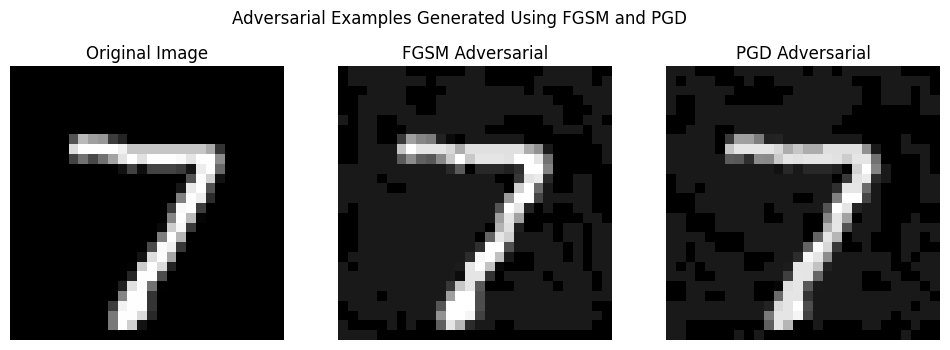

In [18]:
# optional Visualize some of the generated adversarial examples
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# Original image
axes[0].imshow(x_test[0].reshape(28, 28), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# FGSM adversarial image
axes[1].imshow(x_test_adv_fgsm[0].reshape(28, 28), cmap='gray')
axes[1].set_title("FGSM Adversarial")
axes[1].axis('off')

# PGD adversarial image
axes[2].imshow(x_test_adv_pgd[0].reshape(28, 28), cmap='gray')
axes[2].set_title("PGD Adversarial")
axes[2].axis('off')

plt.suptitle("Adversarial Examples Generated Using FGSM and PGD")
plt.show()

**Step 6: Data Poisoning - Inject Adversarial Examples into Training Set**

In [19]:
# Generate adversarial examples from the training set using FGSM
x_train_adv = fgsm_attack.generate(x=x_train, batch_size=64)

# Create a poisoned training set by combining original and adversarial examples
x_train_poisoned = np.concatenate((x_train, x_train_adv))
y_train_poisoned = np.concatenate((y_train, y_train))

In [20]:
# optional Shuffle the poisoned dataset
shuffle_idx = np.random.permutation(len(x_train_poisoned))
x_train_poisoned = x_train_poisoned[shuffle_idx]
y_train_poisoned = y_train_poisoned[shuffle_idx]

In [21]:
# optional Clone the original model and transfer weights
model_poisoned = tf.keras.models.clone_model(model)
model_poisoned.set_weights(model.get_weights())
model_poisoned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-5)

In [23]:
# Retrain the model on poisoned training data with early stopping
history_poisoned = model_poisoned.fit(
    x_train_poisoned, y_train_poisoned,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9754 - loss: 0.0892 - val_accuracy: 0.9919 - val_loss: 0.0342 - learning_rate: 0.0010
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9891 - loss: 0.0404 - val_accuracy: 0.9922 - val_loss: 0.0335 - learning_rate: 0.0010
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9911 - loss: 0.0298 - val_accuracy: 0.9928 - val_loss: 0.0408 - learning_rate: 0.0010
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9935 - loss: 0.0231 - val_accuracy: 0.9917 - val_loss: 0.0459 - learning_rate: 0.0010
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9934 - loss: 0.0223 - val_accuracy: 0.9931 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9947 - loss: 0.0176 - val_accuracy: 0.9940 - val_loss: 0.0427 - learning_rate: 0.0010
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9946

In [24]:
# Evaluate the model on clean and adversarial test data
clean_accuracy_poisoned = model_poisoned.evaluate(x_test, y_test, verbose=0)
fgsm_accuracy_poisoned = model_poisoned.evaluate(x_test_adv_fgsm, y_test, verbose=0)

# Evaluate on PGD adversarial examples
x_test_adv_pgd = pgd_attack.generate(x=x_test, batch_size=64)
pgd_accuracy_poisoned = model_poisoned.evaluate(x_test_adv_pgd, y_test, verbose=0)

PGD - Batches: 0it [00:00, ?it/s]

In [25]:
# Print the evaluation results
print(f"Poisoned model accuracy on clean test data: {clean_accuracy_poisoned[1]:.4f}")
print(f"Poisoned model accuracy on FGSM adversarial data: {fgsm_accuracy_poisoned[1]:.4f}")
print(f"Poisoned model accuracy on PGD adversarial data: {pgd_accuracy_poisoned[1]:.4f}")

Poisoned model accuracy on clean test data: 0.9953
Poisoned model accuracy on FGSM adversarial data: 0.9944
Poisoned model accuracy on PGD adversarial data: 0.9936


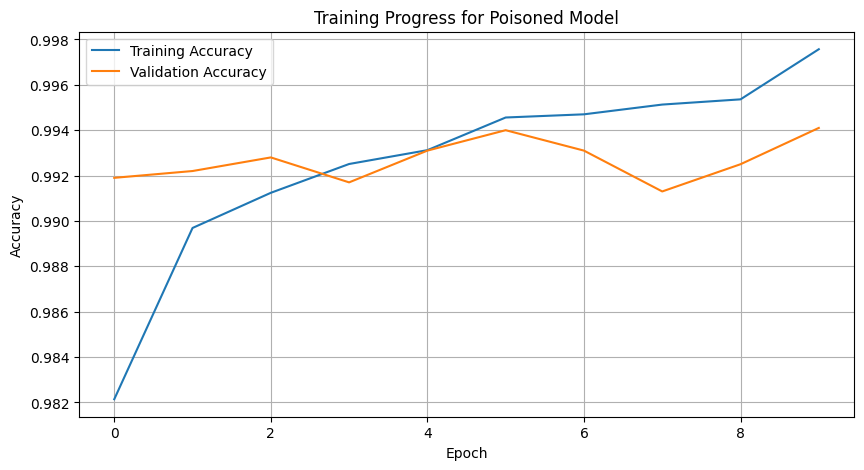

In [26]:
# optional Visualize the training history
plt.figure(figsize=(10, 5))
plt.plot(history_poisoned.history['accuracy'], label='Training Accuracy')
plt.plot(history_poisoned.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Progress for Poisoned Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Step 7: Apply Defense - Adversarial Training**

In [27]:
# Define the optimizer separately
optimizer = tf.keras.optimizers.Adam()

# Create TensorFlowV2Classifier with the correct optimizer
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=10,
    input_shape=(28, 28, 1),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    clip_values=(0.0, 1.0),  # Ensure inputs stay in the valid range
    optimizer=optimizer  # Use the correct attribute here
)


In [28]:
# Use a smaller subset of the training data to speed up adversarial training
subset_size = 5000  # Adjust this size based on your needs and system capabilities
x_train_subset = x_train[:subset_size]
y_train_subset = y_train[:subset_size]

# Apply adversarial training on the subset
trainer = AdversarialTrainer(classifier, attacks=[fgsm_attack, pgd_attack], ratio=0.5)
trainer.fit(x_train_subset, y_train_subset, nb_epochs=5, batch_size=64)

# Get the defended classifier
defended_classifier = trainer.get_classifier()

# Convert one-hot encoded labels to integers for evaluation
y_test_labels = np.argmax(y_test, axis=1)


Precompute adv samples:   0%|          | 0/2 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

In [30]:
# Step 7.4: Evaluate the defended model on clean test data
y_pred_clean = defended_classifier.predict(x_test, batch_size=64)
defended_accuracy_clean = accuracy_score(y_test_labels, np.argmax(y_pred_clean, axis=1))
print(f"Defended model accuracy on clean test data: {defended_accuracy_clean:.4f}")

# Step 7.5: Evaluate the defended model on FGSM adversarial examples
y_pred_fgsm = defended_classifier.predict(x_test_adv_fgsm, batch_size=64)
defended_accuracy_fgsm = accuracy_score(y_test_labels, np.argmax(y_pred_fgsm, axis=1))
print(f"Defended model accuracy on FGSM adversarial data: {defended_accuracy_fgsm:.4f}")

# Step 7.6: Evaluate the defended model on PGD adversarial examples
y_pred_pgd = defended_classifier.predict(x_test_adv_pgd, batch_size=64)
defended_accuracy_pgd = accuracy_score(y_test_labels, np.argmax(y_pred_pgd, axis=1))
print(f"Defended model accuracy on PGD adversarial data: {defended_accuracy_pgd:.4f}")

Defended model accuracy on clean test data: 0.9939
Defended model accuracy on FGSM adversarial data: 0.9828
Defended model accuracy on PGD adversarial data: 0.9837


In [33]:
# Step 7.7: Optional - Evaluate the defended model on DeepFool adversarial examples
subset_size = 200  # Use a subset for faster evaluation
x_test_subset = x_test[:subset_size]
y_test_subset = y_test_labels[:subset_size]

# Create a DeepFool attack object with the defended classifier
deepfool_attack = DeepFool(classifier=defended_classifier, max_iter=10)
x_test_adv_deepfool = deepfool_attack.generate(x=x_test_subset, batch_size=min(32, subset_size))

# Predict on DeepFool adversarial examples
y_pred_deepfool = defended_classifier.predict(x_test_adv_deepfool, batch_size=min(32, subset_size))
defended_accuracy_deepfool = accuracy_score(y_test_subset, np.argmax(y_pred_deepfool, axis=1))
print(f"Defended model accuracy on DeepFool adversarial data (subset): {defended_accuracy_deepfool:.4f}")

DeepFool:   0%|          | 0/200 [00:00<?, ?it/s]

Defended model accuracy on DeepFool adversarial data (subset): 0.2900


**Step 8: Evaluate the Model Using DeepFool Attack**

In [34]:
# Limit the test set size for faster processing
subset_size = 200  # Adjust the subset size to reduce computation time
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]

# Convert one-hot encoded labels back to integers for the subset
y_test_labels_subset = np.argmax(y_test_subset, axis=1)

In [35]:
# Generate adversarial examples using DeepFool
deepfool_attack = DeepFool(classifier=defended_classifier, max_iter=10)
x_test_adv_deepfool = deepfool_attack.generate(x=x_test_subset, batch_size=min(32, subset_size))

# Get predictions for DeepFool adversarial examples
y_pred_deepfool = defended_classifier.predict(x_test_adv_deepfool, batch_size=min(32, subset_size))


DeepFool:   0%|          | 0/200 [00:00<?, ?it/s]

In [37]:
# Calculate accuracy for DeepFool adversarial examples
deepfool_accuracy = accuracy_score(y_test_labels_subset, np.argmax(y_pred_deepfool, axis=1))
print(f"Defended model accuracy on DeepFool adversarial data (subset): {deepfool_accuracy:.4f}")

Defended model accuracy on DeepFool adversarial data (subset): 0.2900


**Step 9: Visualize Clean vs Adversarial Examples**

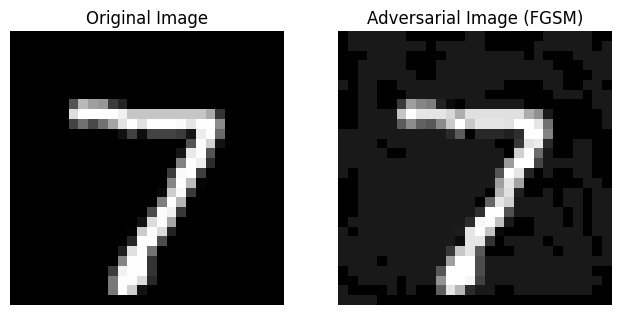

In [38]:
# Step 9.1: Visualize the original and FGSM adversarial examples
plt.figure(figsize=(12, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(x_test[0].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')

# FGSM Adversarial Image
plt.subplot(1, 3, 2)
plt.title("Adversarial Image (FGSM)")
plt.imshow(x_test_adv_fgsm[0].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')

# Step 9.2: Visualize a DeepFool adversarial example
subset_size = 1  # To visualize a single DeepFool adversarial example

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

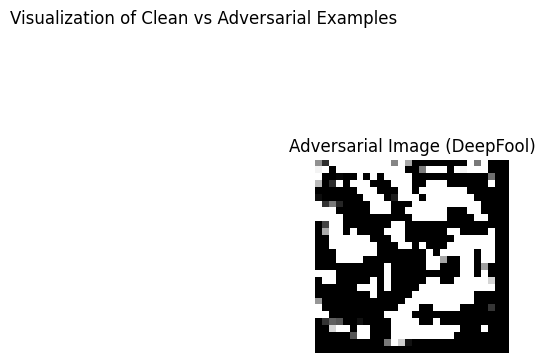

In [39]:
# Generate DeepFool adversarial example using the defended classifier
deepfool_attack_vis = DeepFool(classifier=defended_classifier, max_iter=10)
x_test_adv_deepfool_vis = deepfool_attack_vis.generate(x=x_test[:subset_size], batch_size=1)

# DeepFool Adversarial Image
plt.subplot(1, 3, 3)
plt.title("Adversarial Image (DeepFool)")
plt.imshow(x_test_adv_deepfool_vis[0].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
plt.axis('off')

# Step 9.3: Show the plot
plt.suptitle("Visualization of Clean vs Adversarial Examples")
plt.tight_layout()
plt.show()

**Step 10: Summary of Results**

In [40]:
# Print the original model's accuracy on clean and adversarial data
print("\n--- Final Results ---")

# Accuracy on clean test data using the original model
print(f"Clean Accuracy (Original): {clean_accuracy[1]:.4f}")

# Accuracy on FGSM adversarial examples using the original model
print(f"FGSM Accuracy (Original): {fgsm_accuracy[1]:.4f}")

# Accuracy on PGD adversarial examples using the original model
print(f"PGD Accuracy (Original): {pgd_accuracy[1]:.4f}")


--- Final Results ---
Clean Accuracy (Original): 0.9911
FGSM Accuracy (Original): 0.7313
PGD Accuracy (Original): 0.3845


In [42]:
# Step 10.2: Evaluate the original model on DeepFool adversarial examples
subset_size = 200
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]

# Convert one-hot encoded labels to integers for the subset
y_test_labels_subset = np.argmax(y_test_subset, axis=1)

# Generate DeepFool adversarial examples for the original model
deepfool_attack_original = DeepFool(classifier=classifier, max_iter=10)
x_test_adv_deepfool_original = deepfool_attack_original.generate(x=x_test_subset, batch_size=32)

# Predict on DeepFool adversarial examples
y_pred_deepfool_original = classifier.predict(x_test_adv_deepfool_original, batch_size=32)
deepfool_accuracy_original = accuracy_score(y_test_labels_subset, np.argmax(y_pred_deepfool_original, axis=1))

DeepFool:   0%|          | 0/200 [00:00<?, ?it/s]

In [43]:
print(f"DeepFool Accuracy (Original): {deepfool_accuracy_original:.4f}")

# Print the defended model's accuracy after applying adversarial training
print(f"Clean Accuracy (Defended): {defended_accuracy_clean:.4f}")
print(f"FGSM Accuracy (Defended): {defended_accuracy_fgsm:.4f}")
print(f"PGD Accuracy (Defended): {defended_accuracy_pgd:.4f}")
print(f"DeepFool Accuracy (Defended): {deepfool_accuracy:.4f}")

DeepFool Accuracy (Original): 0.2900
Clean Accuracy (Defended): 0.9939
FGSM Accuracy (Defended): 0.9828
PGD Accuracy (Defended): 0.9837
DeepFool Accuracy (Defended): 0.2900


**Step 11: Visualizing and Summarizing Results**

In [44]:
# Step 11.1: Accuracy values for original and defended models
original_accuracies = [
    clean_accuracy[1],
    fgsm_accuracy[1],
    pgd_accuracy[1],
    deepfool_accuracy_original
]

defended_accuracies = [
    defended_accuracy_clean,
    defended_accuracy_fgsm,
    defended_accuracy_pgd,
    deepfool_accuracy
]

# Step 11.2: Replace None values with 0.0 if any
original_accuracies = [acc if acc is not None else 0.0 for acc in original_accuracies]
defended_accuracies = [acc if acc is not None else 0.0 for acc in defended_accuracies]

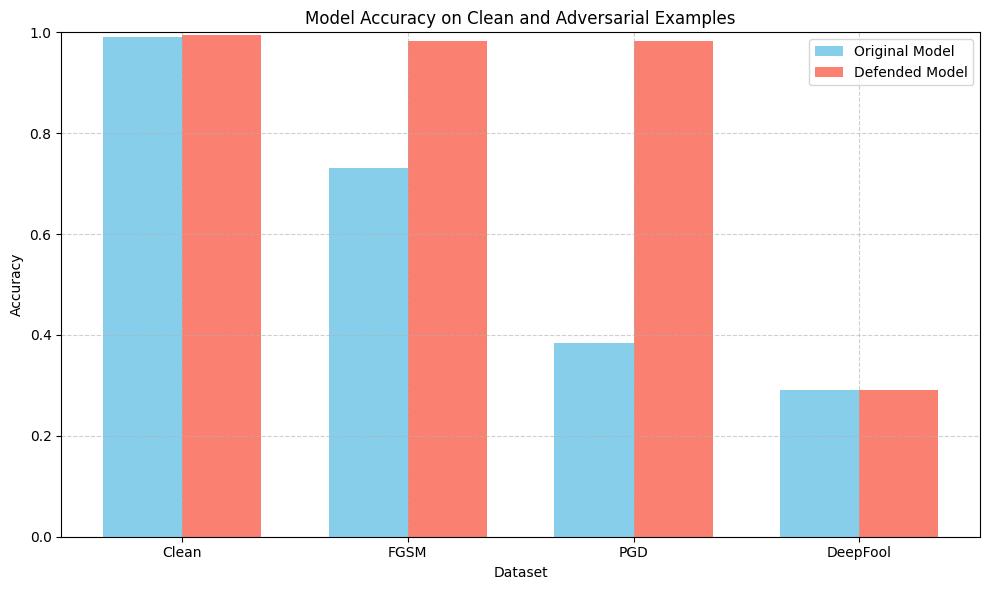

In [46]:
# Step 11.3: Labels for the datasets
labels = ['Clean', 'FGSM', 'PGD', 'DeepFool']

# Step 11.4: Create the bar chart
width = 0.35
x = range(len(labels))
plt.figure(figsize=(10, 6))

# Plot original model accuracies
plt.bar(x, original_accuracies, width, label='Original Model', color='skyblue')

# Plot defended model accuracies next to the original model
plt.bar([i + width for i in x], defended_accuracies, width, label='Defended Model', color='salmon')

# Step 11.5: Add labels, titles, and grid
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Clean and Adversarial Examples')
plt.xticks([i + width / 2 for i in x], labels)
plt.ylim(0, 1)  # Ensures the y-axis is between 0 and 1 since accuracy is a percentage
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Step 11.6: Show the plot
plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------